In [2]:
from torchlibrosa.stft import Spectrogram, LogmelFilterBank
from torchlibrosa.augmentation import SpecAugmentation
import os
import librosa
import torch.nn as nn
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import math
import torch.optim as optim

In [3]:
def interpolate(x, ratio):
    '''Interpolate the prediction to have the same time_steps as the target. 
    The time_steps mismatch is caused by maxpooling in CNN. 
    
    Args:
      x: (batch_size, time_steps, classes_num)
      ratio: int, ratio to upsample
    '''
    (batch_size, time_steps, classes_num) = x.shape
    upsampled = x[:, :, None, :].repeat(1, 1, ratio, 1)
    upsampled = upsampled.reshape(batch_size, time_steps * ratio, classes_num)
    return upsampled

def init_layer(layer):
    """Initialize a Linear or Convolutional layer. """
    nn.init.xavier_uniform_(layer.weight)
 
    if hasattr(layer, 'bias'):
        if layer.bias is not None:
            layer.bias.data.fill_(0.)
            
    
def init_bn(bn):
    """Initialize a Batchnorm layer. """
    bn.bias.data.fill_(0.)
    bn.weight.data.fill_(1.)


def init_gru(rnn):
    """Initialize a GRU layer. """
    
    def _concat_init(tensor, init_funcs):
        (length, fan_out) = tensor.shape
        fan_in = length // len(init_funcs)
    
        for (i, init_func) in enumerate(init_funcs):
            init_func(tensor[i * fan_in : (i + 1) * fan_in, :])
        
    def _inner_uniform(tensor):
        fan_in = nn.init._calculate_correct_fan(tensor, 'fan_in')
        nn.init.uniform_(tensor, -math.sqrt(3 / fan_in), math.sqrt(3 / fan_in))
    
    for i in range(rnn.num_layers):
        _concat_init(
            getattr(rnn, 'weight_ih_l{}'.format(i)),
            [_inner_uniform, _inner_uniform, _inner_uniform]
        )
        torch.nn.init.constant_(getattr(rnn, 'bias_ih_l{}'.format(i)), 0)

        _concat_init(
            getattr(rnn, 'weight_hh_l{}'.format(i)),
            [_inner_uniform, _inner_uniform, nn.init.orthogonal_]
        )
        torch.nn.init.constant_(getattr(rnn, 'bias_hh_l{}'.format(i)), 0)
        
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        
        super(ConvBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                              out_channels=out_channels,
                              kernel_size=(3, 3), stride=(1, 1),
                              padding=(1, 1), bias=False)
                              
        self.conv2 = nn.Conv2d(in_channels=out_channels, 
                              out_channels=out_channels,
                              kernel_size=(3, 3), stride=(1, 1),
                              padding=(1, 1), bias=False)
                              
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.init_weight()
        
    def init_weight(self):
        init_layer(self.conv1)
        init_layer(self.conv2)
        init_bn(self.bn1)
        init_bn(self.bn2)

        
    def forward(self, input, pool_size=(2, 2), pool_type='avg'):
        
        x = input
        x = F.relu_(self.bn1(self.conv1(x)))
        x = F.relu_(self.bn2(self.conv2(x)))
        if pool_type == 'max':
            x = F.max_pool2d(x, kernel_size=pool_size)
        elif pool_type == 'avg':
            x = F.avg_pool2d(x, kernel_size=pool_size)
        elif pool_type == 'avg+max':
            x1 = F.avg_pool2d(x, kernel_size=pool_size)
            x2 = F.max_pool2d(x, kernel_size=pool_size)
            x = x1 + x2
        else:
            raise Exception('Incorrect argument!')
        
        return x
    

class AttBlock(nn.Module):
    def __init__(self, n_in, n_out, activation='linear', temperature=1.):
        super(AttBlock, self).__init__()
        
        self.activation = activation
        self.temperature = temperature
        self.att = nn.Conv1d(in_channels=n_in, out_channels=n_out, kernel_size=1, stride=1, padding=0, bias=True)
        self.cla = nn.Conv1d(in_channels=n_in, out_channels=n_out, kernel_size=1, stride=1, padding=0, bias=True)
        
        self.bn_att = nn.BatchNorm1d(n_out)
        self.init_weights()
        
    def init_weights(self):
        init_layer(self.att)
        init_layer(self.cla)
        init_bn(self.bn_att)
        
    def forward(self, x):
        # x: (n_samples, n_in, n_time)
        tmp = self.att(x)
        tmp = torch.clamp(tmp, -10, 10)
        att = torch.exp(tmp / self.temperature) + 1e-6
        norm_att = att / torch.sum(att, dim=2)[:, :, None]
        cla = self.nonlinear_transform(self.cla(x))
        x = torch.sum(norm_att * cla, dim=2)
        return x, norm_att, cla

    def nonlinear_transform(self, x):
        if self.activation == 'linear':
            return x
        elif self.activation == 'sigmoid':
            return torch.sigmoid(x)
    

class Tmodel(nn.Module):
    def __init__(self):
        super(Tmodel,self).__init__()
        
        SPEC_HEIGHT = 128
        SPEC_WIDTH = 256
        NUM_MELS = SPEC_HEIGHT
        HOP_LENGTH = int(32000 * 5 / (SPEC_WIDTH - 1)) # sample rate * duration / spec width - 1 == 627
        FMIN = 500
        FMAX = 12500
        classes_num = 398
        self.interpolate_ratio = 8
        
        self.spectrogram_extractor  = Spectrogram(
                    n_fft=2048,
                    hop_length=HOP_LENGTH,
                    freeze_parameters=True)
        
        self.logmel_extractor = LogmelFilterBank(sr=32000,
            n_mels=NUM_MELS, fmin=FMIN, fmax=FMAX, freeze_parameters=True)

        self.spec_augmenter = SpecAugmentation(time_drop_width=64, time_stripes_num=2, 
            freq_drop_width=8, freq_stripes_num=2)
        
        self.bn0 = nn.BatchNorm2d(128)

        self.conv_block1 = ConvBlock(in_channels=1, out_channels=64)
        self.conv_block2 = ConvBlock(in_channels=64, out_channels=128)
        self.conv_block3 = ConvBlock(in_channels=128, out_channels=256)
        self.conv_block4 = ConvBlock(in_channels=256, out_channels=512)

        self.gru = nn.GRU(input_size=512, hidden_size=256, num_layers=1, 
            bias=True, batch_first=True, bidirectional=True)

        self.att_block = AttBlock(n_in=512, n_out=classes_num, activation='sigmoid')
        self.init_weights()
        
    def init_weights(self):
        init_bn(self.bn0)
        init_gru(self.gru)
        
    def forward(self,input,mixup_lambda=None):
        
        x = self.spectrogram_extractor(input)   # (batch_size, 1, time_steps, freq_bins)
        x = self.logmel_extractor(x)    # (batch_size, 1, time_steps, mel_bins)
        
        x = x.transpose(1, 3)
        x = self.bn0(x)
        x = x.transpose(1, 3)
        
        if self.training:
            x = self.spec_augmenter(x)

        # Mixup on spectrogram
        if self.training and mixup_lambda is not None:
            x = do_mixup(x, mixup_lambda)
        
        x = self.conv_block1(x, pool_size=(2, 2), pool_type='avg')
        x = self.conv_block2(x, pool_size=(2, 2), pool_type='avg')
        x = self.conv_block3(x, pool_size=(2, 2), pool_type='avg')
        x = self.conv_block4(x, pool_size=(1, 1), pool_type='avg')

        x = torch.mean(x, dim=3)
        x = x.transpose(1, 2)   # (batch_size, time_steps, channels)
        (x, _) = self.gru(x)
        x = x.transpose(1, 2)

        (clipwise_output, norm_att, cla) = self.att_block(x)
        """cla: (batch_size, classes_num, time_stpes)"""
        
        # Framewise output
        framewise_output = cla.transpose(1, 2)
        framewise_output = interpolate(framewise_output, self.interpolate_ratio)
        
        # Clipwise output
        clipwise_output = torch.mean(framewise_output, dim=1)
        
        output_dict = {
            'framewise_output': framewise_output, 
            'clipwise_output': clipwise_output, 
            'embedding': cla}
            
        return output_dict

In [4]:
#prepareing
import random
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import random

df = pd.read_csv('./asset/birdclef-2021/train_metadata.csv')

folder_path = './asset/birdclef-2021/train_short_audio/'

all_list = list()

all_sec = list()
for pri,sec,file in zip(df['primary_label'],df['secondary_labels'],df['filename']):
    sec_2 = list(sec.replace("'",'').replace('[','').replace(']','').replace(' ','').split(','))  
    sec_2.append(pri)
    if sec_2[0]=='':
        sec_2=sec_2[1:]
    for bird in sec_2:
        all_sec.append(bird)
    filename = os.path.join(folder_path,pri,file)
    all_list.append({'path':filename,'bird':sec_2})

class testData(Dataset):
    def __init__(self,all_list):
        self.all_list = all_list
        
    def __len__(self):
        return len(self.all_list)

    def __getitem__(self,idx):
        return self.all_list[idx]
    
blist = list(set(all_sec))
classes_num= len(blist)

# collate_fn by class type, handling with parameters/frame
'''
class Collator(object):
    def __init__(self,blist,frame_sec=7,sr=32000,number_of_frame=20,classes_num=397):
        self.frame_sec = frame_sec
        self.sr = sr
        self.number_of_frame = number_of_frame
        self.classes_num = classes_num
        self.blist = blist
        
    def __call__(self,batch):
        birds = list()
        frames = list()
        duration = self.frame_sec * self.sr
        
        batch_ind = 0
        wav, _ = librosa.load(batch[batch_ind]['path'],sr=32000)
        
        wav_ind = 0
        while len(frames) < self.number_of_frame:
            if wav_ind+duration>len(wav) and batch_ind<len(batch)-1:
                batch_ind += 1
                wav, _ = librosa.load(batch[batch_ind]['path'],sr=32000)
                wav_ind = 0
            else:
                frame = wav[wav_ind:wav_ind+duration]
                frames.append(frame[np.newaxis])
                
                bird_arr = np.zeros((1,self.classes_num))
                for bird in batch[batch_ind]['bird']:
                    bird_arr[0][self.blist.index(bird)]=1
                    birds.append(bird_arr)
                wav_ind += duration
                
        print(frames)
        frames = np.concatenate(frames)
        birds = np.concatenate(birds)
        
        return frames,birds
'''
class BCEFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, preds, targets):
        bce_loss = nn.BCEWithLogitsLoss(reduction='none')(preds, targets)
        probas = torch.sigmoid(preds)
        loss = targets * self.alpha * \
            (1. - probas)**self.gamma * bce_loss + \
            (1. - targets) * probas**self.gamma * bce_loss
        loss = loss.mean()
        return loss


class BCEFocal2WayLoss(nn.Module):
    def __init__(self, weights=[1, 1], class_weights=None):
        super().__init__()

        self.focal = BCEFocalLoss()

        self.weights = weights

    def forward(self, input, target):
        input_ = input["logit"]
        target = target.float()

        framewise_output = input["framewise_logit"]
        clipwise_output_with_max, _ = framewise_output.max(dim=1)

        loss = self.focal(input_, target)
        aux_loss = self.focal(clipwise_output_with_max, target)

        return self.weights[0] * loss + self.weights[1] * aux_loss
    
class BatchCollator(object):
    def __init__(self,blist,frame_sec=7,sr=32000,classes_num=398):
        self.frame_sec = frame_sec
        self.sr = sr
        self.classes_num = classes_num
        self.blist = blist
        self.duration = frame_sec * sr

    def __call__(self,batch):
        waves = list()
        birds = np.zeros((len(batch),self.classes_num))
        for i,meta in enumerate(batch):
            wav, _ = librosa.load(meta['path'],sr=self.sr)
            if len(wav) < self.duration:
                wav = np.concatenate([wav,np.zeros((self.duration-len(wav)))])[np.newaxis,:]
            else:
                ind = random.randint(0,len(wav)-self.duration)
                wav = wav[ind:ind+self.duration][np.newaxis,:]
            waves.append(wav)
            for bird in meta['bird']:
                birds[i][blist.index(bird)] = 1

        waves = np.concatenate(waves)

        return waves,birds

dataset = testData(all_list)
collator = BatchCollator(blist)
#dataloader = DataLoader(dataset,batch_size=1,shuffle=True,collate_fn=make_batch)
dataloader = DataLoader(dataset,batch_size=20,shuffle=True,collate_fn=collator)

In [5]:
waves =list()
wav_path = './asset/birdclef-2021/train_short_audio/acafly/XC109605.ogg'
wav , _ = librosa.load(wav_path)

waves.append(wav)
wav_path2 = './asset/birdclef-2021/train_short_audio/aldfly/XC134932.ogg'
wav2 , _ = librosa.load(wav_path2)

waves.append(wav2)
maxlen = max([len(i) for i in waves])

waves = np.concatenate([np.concatenate([i,np.zeros((maxlen-len(i)))])[np.newaxis,:] for i in waves])

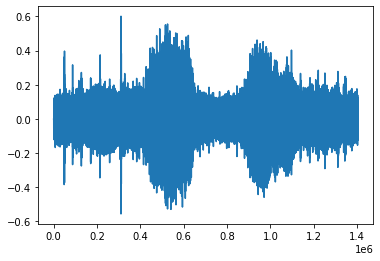

In [6]:
plt.plot(waves[0])

In [8]:
from sklearn import metrics
from autoth.core import HyperParamsOptimizer

class ScoreCalculatorExample(object):
    def __init__(self, batch_size, classes_num):
        """An example of Score calculator. Used to calculate score (such as F1), 
        given prediction, target and hyper parameters. 
        """
        self.N = batch_size     # Number of samples
        self.classes_num = classes_num    # Number of classes
        random_state = np.random.RandomState(1234)

        # Simulate system prediction. Usually a probability. 
        self.prediction = random_state.uniform(0, 1, (self.N, self.classes_num))

        # Simulate ground truth.
        self.target = random_state.randint(0, 2, (self.N, self.classes_num))

    def __call__(self, params):
        """Parameters (such as thresholds) are used calculate score.
        Args:
          params: list of float
        Returns:
          score: float
        """
        thresholds = params
        output = np.zeros_like(self.prediction)

        # Threshold to output
        for n in range(self.N):
            for k in range(self.classes_num):
                if self.prediction[n, k] > thresholds[k]:
                    output[n, k] = 1

        # Calculate score
        score = metrics.f1_score(self.target, output, average='macro')

        return score

In [13]:
import torch
from IPython.display import display
from utils.logging import Averager
from torch.optim import lr_scheduler


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

epochs=15
learning_rate = 0.1
model = Tmodel().to(torch.float32)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, 
        betas=(0.9, 0.999), eps=1e-08, weight_decay=0., amsgrad=True)

score_calculator = ScoreCalculatorExample(dataloader.batch_size, classes_num)
hyper_params_opt = HyperParamsOptimizer(score_calculator,learning_rate=1e-2, epochs=10)

threshold_params = [0.3]*classes_num

model.to(device)
model.train()

avg = Averager()
scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, steps_per_epoch=len(dataloader), epochs=epochs,
                                        pct_start=0.2)
dh = display('',display_id=True)
batch_max = len(dataloader)
for epoch in range(epochs):
    
    #train
    for batch, data in enumerate(dataloader):
        wav, bird = data
        
        wav = torch.from_numpy(wav).to(torch.float32)
        wav = wav.to(device)
        
        bird_smooth = np.where(bird==1,0.995,0.0025)
        bird_smooth = torch.from_numpy(bird_smooth).to(torch.float32).to(device)
        output_dict = model(wav)
        
        loss = F.binary_cross_entropy(output_dict['clipwise_output'], bird_smooth)
        (opt_score, threshold_params) = hyper_params_opt.do_optimize(init_params=threshold_params)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        scheduler.step()
        avg.add(loss)
        dh.update('Epoch : {} {}/{} loss : {} / lr : {} / f1 : {}'.format(\
                                epoch+1,batch+1,batch_max,avg.val(),\
                                optimizer.param_groups[0]['lr'],opt_score))
        
        
        del wav, bird, loss, output_dict, data
        torch.save(model.state_dict(),os.path.join('./result/sed_v1.pth'))
    #eval
    

''

Optimizing hyper parameters ...
learning rate: 0.010, total epochs: 10
    Hyper parameters: [0.2902, 0.3097, 0.3067, 0.3089, 0.2931, 0.303, 0.3024, 0.3, 0.3091, 0.2902, 0.3029, 0.3071, 0.3, 0.3051, 0.3065, 0.3091, 0.309, 0.291, 0.3, 0.304, 0.2917, 0.3088, 0.2903, 0.2934, 0.3, 0.3022, 0.3029, 0.2902, 0.2909, 0.2949, 0.2963, 0.303, 0.2906, 0.2902, 0.293, 0.3092, 0.2912, 0.303, 0.2903, 0.3043, 0.3, 0.3061, 0.2953, 0.2902, 0.2945, 0.2944, 0.2917, 0.3076, 0.2902, 0.3091, 0.3, 0.2947, 0.2919, 0.3019, 0.3057, 0.2903, 0.3023, 0.3, 0.2969, 0.2915, 0.2938, 0.3, 0.3056, 0.2926, 0.2915, 0.2944, 0.3065, 0.2939, 0.2925, 0.3, 0.2935, 0.3027, 0.2942, 0.2912, 0.2946, 0.2916, 0.2913, 0.2912, 0.291, 0.3084, 0.3069, 0.2923, 0.3, 0.3, 0.309, 0.2915, 0.3, 0.2948, 0.2902, 0.3, 0.3, 0.3026, 0.2945, 0.3045, 0.2926, 0.3, 0.3042, 0.2902, 0.2958, 0.2907, 0.2918, 0.3, 0.2912, 0.3, 0.3, 0.2933, 0.2906, 0.3, 0.2935, 0.2924, 0.2904, 0.3037, 0.3, 0.2902, 0.2951, 0.3083, 0.2902, 0.2901, 0.2902, 0.3028, 0.3, 0.2954, 0.

    Hyper parameters: [0.2644, 0.3353, 0.3317, 0.3051, 0.2676, 0.3174, 0.3144, 0.3, 0.3028, 0.2682, 0.3169, 0.3127, 0.3, 0.3276, 0.332, 0.3247, 0.298, 0.264, 0.3, 0.3244, 0.266, 0.3095, 0.2645, 0.3063, 0.3, 0.3129, 0.3169, 0.2635, 0.2645, 0.3019, 0.271, 0.3187, 0.2654, 0.2742, 0.2729, 0.314, 0.2645, 0.3173, 0.2614, 0.3256, 0.3, 0.3307, 0.2877, 0.2643, 0.2736, 0.2742, 0.2653, 0.3275, 0.2663, 0.3325, 0.3, 0.2738, 0.3053, 0.3114, 0.3298, 0.2646, 0.3136, 0.3, 0.2832, 0.2648, 0.2705, 0.3, 0.3311, 0.2681, 0.2643, 0.273, 0.3234, 0.2685, 0.2677, 0.3, 0.2703, 0.3158, 0.2683, 0.2645, 0.2738, 0.2701, 0.2646, 0.2645, 0.2639, 0.3085, 0.3293, 0.2667, 0.3, 0.3, 0.3267, 0.2654, 0.3, 0.2743, 0.2644, 0.3, 0.3, 0.3157, 0.273, 0.3265, 0.2676, 0.3, 0.3241, 0.2643, 0.2784, 0.2627, 0.2648, 0.3, 0.2651, 0.3, 0.3, 0.2692, 0.2627, 0.3, 0.2883, 0.2934, 0.2617, 0.3194, 0.3, 0.2634, 0.2872, 0.3218, 0.2621, 0.2634, 0.2644, 0.3162, 0.3, 0.2781, 0.2752, 0.2643, 0.2856, 0.3311, 0.3214, 0.3277, 0.3, 0.2639, 0.268, 0.26

    Hyper parameters: [0.2427, 0.3535, 0.3463, 0.3058, 0.2437, 0.3378, 0.3313, 0.3, 0.3087, 0.2644, 0.3374, 0.3156, 0.3, 0.3375, 0.3541, 0.3273, 0.2979, 0.2415, 0.3, 0.3453, 0.2409, 0.31, 0.2414, 0.3028, 0.3, 0.329, 0.3364, 0.2382, 0.2404, 0.2958, 0.26, 0.3411, 0.2549, 0.2737, 0.2601, 0.3059, 0.239, 0.3373, 0.2458, 0.3516, 0.3, 0.3552, 0.2833, 0.2424, 0.2508, 0.2744, 0.2397, 0.3516, 0.2496, 0.3578, 0.3, 0.2575, 0.3085, 0.3262, 0.3468, 0.2427, 0.3297, 0.3, 0.2664, 0.2606, 0.2457, 0.3, 0.3513, 0.2437, 0.2428, 0.2501, 0.3129, 0.2453, 0.2427, 0.3, 0.2448, 0.3342, 0.2554, 0.2393, 0.2514, 0.2525, 0.2596, 0.2384, 0.2516, 0.2957, 0.3464, 0.2388, 0.3, 0.3, 0.3236, 0.2404, 0.3, 0.2506, 0.242, 0.3, 0.3, 0.3346, 0.2498, 0.343, 0.2522, 0.3, 0.3484, 0.2564, 0.2593, 0.2471, 0.2388, 0.3, 0.2659, 0.3, 0.3, 0.2469, 0.2393, 0.3, 0.291, 0.2934, 0.2352, 0.3411, 0.3, 0.2465, 0.2825, 0.3296, 0.2392, 0.2405, 0.2425, 0.3356, 0.3, 0.2666, 0.2559, 0.2516, 0.301, 0.3571, 0.3416, 0.3399, 0.3, 0.2362, 0.2438, 0.237

KeyboardInterrupt: 

In [ ]:
#inference
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

saved_model = './result/sed.pth'
val_path = './asset/birdclef-2021/train_soundscapes/'
val_list = [i for i in os.listdir(val_path) if i.split('.')[-1]=='ogg']
val_df = pd.read_csv('./asset/birdclef-2021/train_soundscape_labels.csv')

classes_list = np.array(blist)

model = Tmodel().to(torch.float32)
model.load_state_dict(torch.load(saved_model,map_location=device))
model.to(device)

model.eval()
for sound_scape in val_list:
    sr = 32000
    duration = 5 * sr
    scape, _ = librosa.load(os.path.join(val_path,sound_scape),sr=sr)
    
    for i in range(0,len(scape),duration):
        temp = scape[i:i+duration]
        temp = torch.from_numpy(temp[np.newaxis,:]).to(device)
        output_dict = model(temp)
        
        output_pred = output_dict['clipwise_output'].cpu().detach().numpy()
        pred = classes_list[output_pred[0]>0.03]
        print(pred)

In [15]:
output_pred[0]

array([7.72674030e-05, 8.32735386e-05, 8.73663303e-05, 5.93038021e-05,
       1.02584294e-04, 7.76490560e-05, 2.10788159e-04, 5.54342005e-05,
       1.05157815e-04, 1.11761707e-04, 2.49704346e-04, 5.45745534e-05,
       2.13419509e-04, 9.79089527e-05, 8.89313669e-05, 1.04112936e-04,
       1.29907610e-04, 6.13467928e-05, 6.70758454e-05, 3.68852052e-05,
       1.49424421e-04, 1.08961693e-04, 2.49427481e-04, 4.65938756e-05,
       8.22638976e-05, 4.81108145e-05, 2.41485843e-03, 8.82633904e-05,
       5.50324839e-05, 2.03678996e-04, 1.00064251e-04, 2.66559975e-04,
       8.47917836e-05, 7.79983748e-05, 5.03541669e-04, 7.74042564e-05,
       4.54095192e-04, 1.44496188e-03, 1.50909938e-04, 1.27710402e-04,
       6.29137794e-05, 7.94669031e-05, 5.79749139e-05, 1.16624054e-03,
       7.22384197e-04, 1.48095249e-04, 6.66684718e-05, 3.20672698e-04,
       1.21206707e-04, 1.37347961e-04, 1.18023483e-04, 1.48119288e-04,
       1.65133300e-04, 1.08969602e-04, 4.64126177e-04, 2.58609041e-04,
      

In [10]:
print(model)

Tmodel(
  (spectrogram_extractor): Spectrogram(
    (stft): STFT(
      (conv_real): Conv1d(1, 1025, kernel_size=(2048,), stride=(627,), bias=False)
      (conv_imag): Conv1d(1, 1025, kernel_size=(2048,), stride=(627,), bias=False)
    )
  )
  (logmel_extractor): LogmelFilterBank()
  (spec_augmenter): SpecAugmentation(
    (time_dropper): DropStripes()
    (freq_dropper): DropStripes()
  )
  (bn0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_block1): ConvBlock(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_block2): ConvBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  

# Version 2 inference

In [5]:

def init_layer(layer):
    """Initialize a Linear or Convolutional layer. """
    nn.init.xavier_uniform_(layer.weight)
 
    if hasattr(layer, 'bias'):
        if layer.bias is not None:
            layer.bias.data.fill_(0.)
            
    
def init_bn(bn):
    """Initialize a Batchnorm layer. """
    bn.bias.data.fill_(0.)
    bn.weight.data.fill_(1.)


def init_gru(rnn):
    """Initialize a GRU layer. """
    
    def _concat_init(tensor, init_funcs):
        (length, fan_out) = tensor.shape
        fan_in = length // len(init_funcs)
    
        for (i, init_func) in enumerate(init_funcs):
            init_func(tensor[i * fan_in : (i + 1) * fan_in, :])
        
    def _inner_uniform(tensor):
        fan_in = nn.init._calculate_correct_fan(tensor, 'fan_in')
        nn.init.uniform_(tensor, -math.sqrt(3 / fan_in), math.sqrt(3 / fan_in))
    
    for i in range(rnn.num_layers):
        _concat_init(
            getattr(rnn, 'weight_ih_l{}'.format(i)),
            [_inner_uniform, _inner_uniform, _inner_uniform]
        )
        torch.nn.init.constant_(getattr(rnn, 'bias_ih_l{}'.format(i)), 0)

        _concat_init(
            getattr(rnn, 'weight_hh_l{}'.format(i)),
            [_inner_uniform, _inner_uniform, nn.init.orthogonal_]
        )
        torch.nn.init.constant_(getattr(rnn, 'bias_hh_l{}'.format(i)), 0)
        
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        
        super(ConvBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                              out_channels=out_channels,
                              kernel_size=(3, 3), stride=(1, 1),
                              padding=(1, 1), bias=False)
                              
        self.conv2 = nn.Conv2d(in_channels=out_channels, 
                              out_channels=out_channels,
                              kernel_size=(3, 3), stride=(1, 1),
                              padding=(1, 1), bias=False)
                              
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.init_weight()
        
    def init_weight(self):
        init_layer(self.conv1)
        init_layer(self.conv2)
        init_bn(self.bn1)
        init_bn(self.bn2)

        
    def forward(self, input, pool_size=(2, 2), pool_type='avg'):
        
        x = input
        x = F.relu_(self.bn1(self.conv1(x)))
        x = F.relu_(self.bn2(self.conv2(x)))
        if pool_type == 'max':
            x = F.max_pool2d(x, kernel_size=pool_size)
        elif pool_type == 'avg':
            x = F.avg_pool2d(x, kernel_size=pool_size)
        elif pool_type == 'avg+max':
            x1 = F.avg_pool2d(x, kernel_size=pool_size)
            x2 = F.max_pool2d(x, kernel_size=pool_size)
            x = x1 + x2
        else:
            raise Exception('Incorrect argument!')
        
        return x
    

class AttBlockV2(nn.Module):
    def __init__(self,
                 in_features: int,
                 out_features: int,
                 activation="linear"):
        super().__init__()

        self.activation = activation
        self.att = nn.Conv1d(
            in_channels=in_features,
            out_channels=out_features,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True)
        self.cla = nn.Conv1d(
            in_channels=in_features,
            out_channels=out_features,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True)

        self.init_weights()

    def init_weights(self):
        init_layer(self.att)
        init_layer(self.cla)

    def forward(self, x):
        # x: (n_samples, n_in, n_time)
        norm_att = torch.softmax(torch.tanh(self.att(x)), dim=-1)
        cla = self.nonlinear_transform(self.cla(x))
        x = torch.sum(norm_att * cla, dim=2)
        return x, norm_att, cla

    def nonlinear_transform(self, x):
        if self.activation == 'linear':
            return x
        elif self.activation == 'sigmoid':
            return torch.sigmoid(x)

    

class Tmodel(nn.Module):
    def __init__(self,train=True):
        super(Tmodel,self).__init__()
        
        SPEC_HEIGHT = 128
        SPEC_WIDTH = 256
        NUM_MELS = SPEC_HEIGHT
        HOP_LENGTH = int(32000 * 5 / (SPEC_WIDTH - 1)) # sample rate * duration / spec width - 1 == 627
        FMIN = 500
        FMAX = 12500
        classes_num = 398
        self.interpolate_ratio = 8
        
        self.spectrogram_extractor  = Spectrogram(
                    n_fft=2048,
                    hop_length=HOP_LENGTH,
                    freeze_parameters=True)
        
        self.logmel_extractor = LogmelFilterBank(sr=32000,
            n_mels=NUM_MELS, fmin=FMIN, fmax=FMAX, freeze_parameters=True)

        self.spec_augmenter = SpecAugmentation(time_drop_width=64, time_stripes_num=2, 
            freq_drop_width=8, freq_stripes_num=2)
        
        self.bn0 = nn.BatchNorm2d(128)

        # load pretrained models, using ResNeSt-50 as an example
        if train:
            base_model = torch.hub.load('zhanghang1989/ResNeSt', 'resnest50', pretrained=True)
        else:
            base_model = torch.hub.load('zhanghang1989/ResNeSt', 'resnest50', pretrained=False)
            
        layers = list(base_model.children())[:-2]
        self.encoder = nn.Sequential(*layers)
        
        self.gru = nn.GRU(input_size=2048, hidden_size=1024, num_layers=1, 
            bias=True, batch_first=True, bidirectional=True)

        self.att_block = AttBlockV2(2048, classes_num, activation='sigmoid')
        self.init_weights()
        
    def init_weights(self):
        init_bn(self.bn0)
        init_gru(self.gru)
        
    def forward(self,input,mixup_lambda=None):
        
        x = self.spectrogram_extractor(input)   # (batch_size, 1, time_steps, freq_bins)
        x = self.logmel_extractor(x)    # (batch_size, 1, time_steps, mel_bins)
        
        frames_num = x.shape[2]
        
        x = x.transpose(1, 3)
        x = self.bn0(x)
        x = x.transpose(1, 3)
        
        if self.training:
            x = self.spec_augmenter(x)
        
        # Mixup on spectrogram
        if self.training and mixup_lambda is not None:
            x = do_mixup(x, mixup_lambda)
        
        x = torch.tile(x,(1,3,1,1))
        x = self.encoder(x)

        x = torch.mean(x, dim=3)
        x = x.transpose(1, 2)   # (batch_size, time_steps, channels)
        (x, _) = self.gru(x)
        x = x.transpose(1, 2)

        (clipwise_output, norm_att, segmentwise_output) = self.att_block(x)
        """cla: (batch_size, classes_num, time_stpes)"""
        
        logit = torch.sum(norm_att * self.att_block.cla(x), dim=2)
        segmentwise_logit = self.att_block.cla(x).transpose(1, 2)
        segmentwise_output = segmentwise_output.transpose(1, 2)

        interpolate_ratio = frames_num // segmentwise_output.size(1)
        
        # Framewise output
        framewise_output = interpolate(segmentwise_output,
                                       interpolate_ratio)
        framewise_output = pad_framewise_output(framewise_output, frames_num)

        framewise_logit = interpolate(segmentwise_logit, interpolate_ratio)
        framewise_logit = pad_framewise_output(framewise_logit, frames_num)
        
        output_dict = {
            "framewise_output": framewise_output,
            "segmentwise_output": segmentwise_output,
            "logit": logit,
            "framewise_logit": framewise_logit,
            "clipwise_output": clipwise_output
        }

            
        return output_dict
    
def interpolate(x: torch.Tensor, ratio: int):
    """Interpolate data in time domain. This is used to compensate the
    resolution reduction in downsampling of a CNN.
    Args:
      x: (batch_size, time_steps, classes_num)
      ratio: int, ratio to interpolate
    Returns:
      upsampled: (batch_size, time_steps * ratio, classes_num)
    """
    (batch_size, time_steps, classes_num) = x.shape
    upsampled = x[:, :, None, :].repeat(1, 1, ratio, 1)
    upsampled = upsampled.reshape(batch_size, time_steps * ratio, classes_num)
    return upsampled


def pad_framewise_output(framewise_output: torch.Tensor, frames_num: int):
    """Pad framewise_output to the same length as input frames. The pad value
    is the same as the value of the last frame.
    Args:
      framewise_output: (batch_size, frames_num, classes_num)
      frames_num: int, number of frames to pad
    Outputs:
      output: (batch_size, frames_num, classes_num)
    """
    output = F.interpolate(
        framewise_output.unsqueeze(1),
        size=(frames_num, framewise_output.size(2)),
        align_corners=True,
        mode="bilinear").squeeze(1)

    return output

In [6]:
#train
import torch
from IPython.display import display
from utils.logging import Averager
from torch.optim import lr_scheduler
from utils.loss import AsymmetricLoss

#learning_rate = 0.1 #for onecycle
learning_rate = 0.01  #for cosine

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

epochs=15
model = Tmodel().to(torch.float32)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, 
        betas=(0.9, 0.999), eps=1e-08, weight_decay=0., amsgrad=True)

model.to(device)
model.train()

avg = Averager()
#scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, steps_per_epoch=len(dataloader), epochs=epochs,
#                                        pct_start=0.2)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
dh = display('',display_id=True)
batch_max = len(dataloader)
loss_func = BCEFocal2WayLoss()
for epoch in range(epochs):
    
    #train
    for batch, data in enumerate(dataloader):
        wav, bird = data
        
        wav = torch.from_numpy(wav).to(torch.float32)
        wav = wav.to(device)
        
        bird_smooth = np.where(bird==1,0.995,0.0025)
        bird_smooth = torch.from_numpy(bird_smooth).to(torch.float32).to(device)
        output_dict = model(wav)
        
        loss = loss_func(output_dict, bird_smooth)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        scheduler.step()
        avg.add(loss)
        dh.update('Epoch : {} {}/{} loss : {} / lr : {}'.format(\
                                epoch+1,batch+1,batch_max,avg.val(),\
                                optimizer.param_groups[0]['lr']))
        
        del wav, bird, loss, output_dict, data
        torch.save(model.state_dict(),os.path.join('./result/sed_asloss.pth'))
    #eval
    

Using cache found in /root/.cache/torch/hub/zhanghang1989_ResNeSt_master


KeyboardInterrupt: 

In [19]:
#inference
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

saved_model = './result/sed.pth'
val_path = './asset/birdclef-2021/train_soundscapes/'
val_list = [i for i in os.listdir(val_path) if i.split('.')[-1]=='ogg']
val_df = pd.read_csv('./asset/birdclef-2021/train_soundscape_labels.csv')

classes_list = np.array(blist)

model = Tmodel(False).to(torch.float32)
model.load_state_dict(torch.load(saved_model,map_location=device))
model.to(device)

model.eval()
for sound_scape in val_list:
    sr = 32000
    duration = 5 * sr
    scape, _ = librosa.load(os.path.join(val_path,sound_scape),sr=sr)
    
    for i in range(0,len(scape),duration):
        temp = scape[i:i+duration]
        temp = torch.from_numpy(temp[np.newaxis,:]).to(device)
        output_dict = model(temp)
        
        output_pred = output_dict['clipwise_output'].cpu().detach().numpy()
        pred = classes_list[output_pred[0]>0.3]
        print(sound_scape,pred)

Using cache found in /root/.cache/torch/hub/zhanghang1989_ResNeSt_master


2782_SSW_20170701.ogg []
2782_SSW_20170701.ogg []
2782_SSW_20170701.ogg []
2782_SSW_20170701.ogg ['rucwar']
2782_SSW_20170701.ogg []
2782_SSW_20170701.ogg ['brbmot1' 'goowoo1' 'comgol' 'gockin']
2782_SSW_20170701.ogg []
2782_SSW_20170701.ogg ['brbmot1']
2782_SSW_20170701.ogg ['brbmot1' 'goowoo1' 'comgol' 'trogna1']
2782_SSW_20170701.ogg ['brbmot1']
2782_SSW_20170701.ogg ['brbmot1' 'goowoo1']
2782_SSW_20170701.ogg ['brbmot1' 'goowoo1']
2782_SSW_20170701.ogg ['brbmot1' 'goowoo1']
2782_SSW_20170701.ogg ['brbmot1']
2782_SSW_20170701.ogg []
2782_SSW_20170701.ogg []
2782_SSW_20170701.ogg ['rucwar']
2782_SSW_20170701.ogg ['norfli' 'brbmot1']
2782_SSW_20170701.ogg ['brbmot1']
2782_SSW_20170701.ogg ['brbmot1' 'sander']
2782_SSW_20170701.ogg ['trogna1']
2782_SSW_20170701.ogg ['brbmot1' 'goowoo1' 'comgol' 'trogna1']
2782_SSW_20170701.ogg ['brbmot1' 'trogna1']
2782_SSW_20170701.ogg ['brbmot1' 'sander']
2782_SSW_20170701.ogg ['brbmot1' 'goowoo1' 'comgol']
2782_SSW_20170701.ogg []
2782_SSW_20170701.

14473_SSW_20170701.ogg []
14473_SSW_20170701.ogg ['fiespa' 'canwar']
14473_SSW_20170701.ogg []
14473_SSW_20170701.ogg []
14473_SSW_20170701.ogg ['fiespa']
14473_SSW_20170701.ogg []
14473_SSW_20170701.ogg []
14473_SSW_20170701.ogg []
14473_SSW_20170701.ogg []
14473_SSW_20170701.ogg []
14473_SSW_20170701.ogg []
14473_SSW_20170701.ogg []
14473_SSW_20170701.ogg []
14473_SSW_20170701.ogg []
14473_SSW_20170701.ogg []
14473_SSW_20170701.ogg []
14473_SSW_20170701.ogg []
14473_SSW_20170701.ogg []
14473_SSW_20170701.ogg []
14473_SSW_20170701.ogg ['gcrwar']
14473_SSW_20170701.ogg ['gcrwar']
14473_SSW_20170701.ogg []
14473_SSW_20170701.ogg ['gcrwar']
14473_SSW_20170701.ogg []
14473_SSW_20170701.ogg []
14473_SSW_20170701.ogg []
14473_SSW_20170701.ogg []
14473_SSW_20170701.ogg []
14473_SSW_20170701.ogg []
14473_SSW_20170701.ogg []


KeyboardInterrupt: 

In [6]:
#train
import torch
from IPython.display import display
from utils.logging import Averager
from torch.optim import lr_scheduler
from utils.loss import AsymmetricLoss

#learning_rate = 0.1 #for onecycle
learning_rate = 0.01  #for cosine

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

epochs=15
model = Tmodel().to(torch.float32)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, 
        betas=(0.9, 0.999), eps=1e-08, weight_decay=0., amsgrad=True)

model.to(device)
model.train()

avg = Averager()
#scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, steps_per_epoch=len(dataloader), epochs=epochs,
#                                        pct_start=0.2)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
dh = display('',display_id=True)
batch_max = len(dataloader)
loss_func = BCEFocal2WayLoss()
for epoch in range(epochs):
    
    #train
    for batch, data in enumerate(dataloader):
        wav, bird = data
        
        wav = torch.from_numpy(wav).to(torch.float32)
        wav = wav.to(device)
        
        bird_smooth = np.where(bird==1,0.995,0.0025)
        bird_smooth = torch.from_numpy(bird_smooth).to(torch.float32).to(device)
        output_dict = model(wav)
        
        loss = loss_func(output_dict, bird_smooth)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        scheduler.step()
        avg.add(loss)
        dh.update('Epoch : {} {}/{} loss : {} / lr : {}'.format(\
                                epoch+1,batch+1,batch_max,avg.val(),\
                                optimizer.param_groups[0]['lr']))
        
        #del wav, bird, loss, output_dict, data
        torch.save(model.state_dict(),os.path.join('./result/sed_asloss.pth'))
    #eval
    break

Using cache found in /root/.cache/torch/hub/zhanghang1989_ResNeSt_master


'Epoch : 1 21/3144 loss : 0.05718204006552696 / lr : 0.009755282581475812'

KeyboardInterrupt: 

In [12]:
bird

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [13]:
output_dict['clipwise_output']

tensor([[0.0047, 0.0058, 0.0096,  ..., 0.0081, 0.0099, 0.0387],
        [0.0047, 0.0058, 0.0096,  ..., 0.0081, 0.0099, 0.0387],
        [0.0047, 0.0058, 0.0096,  ..., 0.0081, 0.0099, 0.0387],
        ...,
        [0.0047, 0.0058, 0.0096,  ..., 0.0081, 0.0099, 0.0387],
        [0.0047, 0.0058, 0.0096,  ..., 0.0081, 0.0099, 0.0387],
        [0.0047, 0.0058, 0.0096,  ..., 0.0081, 0.0099, 0.0387]],
       device='cuda:0', grad_fn=<SumBackward1>)